# Module 2

This notebook includes code on measuring correlation between a stock and a search term. While this can easily be done visually with a graph, having a number allows us to compare and see which are more correlated.
<br>
More correlated searches are more useful for predictive modelling.

In [1]:
# import statements
import pandas as pd

In [2]:
# import the data
# I am including two search terms here to compare results
search_df1 = pd.read_csv("recession_search_data.csv", header=1)
search_df2 = pd.read_csv("peach_search_data.csv", header=1)
stock_df = pd.read_csv("^GSPTSE.csv")


search_df1.rename(columns={ search_df1.columns[1]: "search_freq1" }, inplace = True)
search_df2.rename(columns={ search_df2.columns[1]: "search_freq2" }, inplace = True)

In [3]:
# Use .head() to show the start of the data frame and .tail() to show the end
display(pd.concat([search_df1.head(3),search_df1.tail(3)]))
display(pd.concat([search_df2.head(3),search_df2.tail(3)]))
display(pd.concat([stock_df.head(3),stock_df.tail(3)]))

,Week,search_freq1
0,2017-10-15,4
1,2017-10-22,5
2,2017-10-29,4
257,2022-09-18,33
258,2022-09-25,39
259,2022-10-02,36


,Week,search_freq2
0,2017-10-22,12
1,2017-10-29,13
2,2017-11-05,14
257,2022-09-25,27
258,2022-10-02,24
259,2022-10-09,20


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-10-09,15763.599609,15828.900391,15742.200195,15807.200195,15807.200195,613083200
1,2017-10-16,15844.000000,15880.700195,15754.099609,15857.200195,15857.200195,802654100
2,2017-10-23,15881.599609,15963.599609,15816.500000,15953.500000,15953.500000,875908700
259,2022-09-26,18405.300781,18703.900391,18247.699219,18444.199219,18444.199219,1277886000
260,2022-10-03,18621.800781,19405.099609,18522.599609,18583.099609,18583.099609,1235511700
261,2022-10-07,18849.099609,18849.289063,18522.550781,18583.130859,18583.130859,237888307


In [4]:
# dropping mismatching rows
stock_df = stock_df.drop(index=[0,1,261])
search_df1 = search_df1.drop(index=[0])
search_df2 = search_df2.drop(index=[259])

In [5]:
# reindexing the df's so they merge properly
stock_df.index = range(len(stock_df))
search_df1.index = range(len(search_df1))
search_df2.index = range(len(search_df2))

In [6]:
# Merging the df's
main_df = stock_df.join(search_df1).join(search_df2["search_freq2"])
main_df.insert(0, 'Week', main_df.pop('Week')) # Moves 'Week' column to the front of the df
main_df

,Week,Date,Open,High,Low,Close,Adj Close,Volume,search_freq1,search_freq2
0,2017-10-22,2017-10-23,15881.599609,15963.599609,15816.500000,15953.500000,15953.500000,875908700,5,12
1,2017-10-29,2017-10-30,15942.900391,16105.900391,15942.900391,16020.200195,16020.200195,995937000,4,13
2,2017-11-05,2017-11-06,16049.400391,16131.799805,16006.299805,16039.299805,16039.299805,953224500,4,14
3,2017-11-12,2017-11-13,15999.099609,16065.900391,15829.400391,15998.599609,15998.599609,811551100,4,14
4,2017-11-19,2017-11-20,15988.799805,16126.000000,15986.000000,16108.099609,16108.099609,610929000,4,13
...,...,...,...,...,...,...,...,...,...,...
254,2022-09-04,2022-09-05,19346.400391,19789.599609,18982.000000,19773.300781,19773.300781,952117900,16,59
255,2022-09-11,2022-09-12,19923.199219,20032.599609,19283.199219,19385.900391,19385.900391,1612419100,24,43
256,2022-09-18,2022-09-19,19203.300781,19569.099609,18372.599609,18481.000000,18481.000000,1254949500,33,33
257,2022-09-25,2022-09-26,18405.300781,18703.900391,18247.699219,18444.199219,18444.199219,1277886000,39,27


<AxesSubplot:xlabel='Date'>

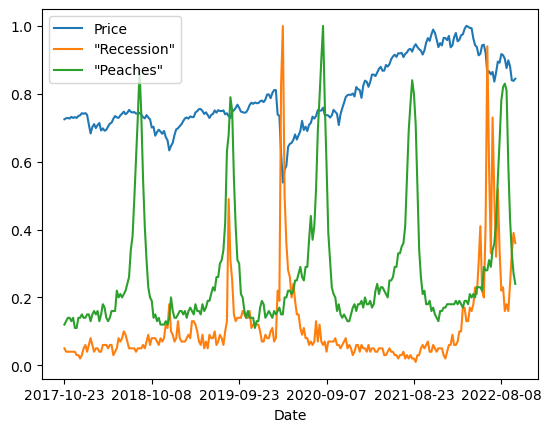

In [7]:
def norm_min_max(df, cols):
    for col in cols:
        df[col] = df[col] /df[col].abs().max()
    
norm_min_max(main_df, ['Adj Close', 'search_freq1', 'search_freq2'])

main_df.rename(columns={ 'Adj Close':'Price', 'search_freq1':'\"Recession\"', 'search_freq2':'\"Peaches\"' }, inplace = True)

# main_df.plot(x='Date', y=['Adj Close', 'search_freq1', 'search_freq2'])


main_df.plot(x='Date', y=['Price', '\"Recession\"', '\"Peaches\"'])

In [10]:
# the function for comparing how similar two columns are in their movements
# takes in a dataframe and columns to compare and returns an float between 0 and 1 representing correlation
# a correlation of near 1 means the two columns share similar peaks and troughs
# a correlation of near 0 means the two columns are inverse to each other
# a correlation of near 0.5 means the two columns are independant, ie. the is no correlation
def measureCorrelation(df, cols):
    if len(cols) != 2:
        print("Invalid number of columns")
        return -1
    
    count_same = 0
    
    for i in range(len(df)-2):
        if df.iloc[i][cols[0]] < df.iloc[i+1][cols[0]]:
            a = 1
        elif df.iloc[i][cols[0]] == df.iloc[i+1][cols[0]]:
            a = 0
        else:
            a = -1
         
        if df.iloc[i][cols[1]] < df.iloc[i+1][cols[1]]:
            b = 1
        elif df.iloc[i][cols[1]] == df.iloc[i+1][cols[1]]:
            b = 0
        else:
            b = -1
            
        if b == a:
            count_same += 1
            
    return count_same / (len(df)-1)

print(measureCorrelation(main_df, ['Adj Close', 'search_freq1']))
print(measureCorrelation(main_df, ['Adj Close', 'search_freq2']))

0.29069767441860467
0.4806201550387597


Correlation can be a good metric for how useful the search term will be in predicting the stock. Keep in mind that the above function is far from perfect, ideally the data would be smoothed or ran through another noise filtering method. 